# Assignment 2

## 2.1 Load images

In this part, I used openCV to read gray images with resizing 64*64 and stored images by a list. Then I used the pandas library to encapsulate file names and images. 

**NOTE**：I cannot run all part at the same time as the capacity of RAM is not big enough for all part loading data. So, when I do not need 1 variable any more, I will use collect function in gc library to reclaim memory, but I do not write this part in this file into the report.

In [1]:
from __future__ import absolute_import, division, print_function
import skimage
import os
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time
import warnings
warnings.filterwarnings("ignore")

dir1 = "/home/jupyter_cnn/assignment2/sub1to10"
dir2 = "/home/jupyter_cnn/assignment2/sub31to40"
def load_images(path):
    image_list = []
    file_list = []
    for root, dirs, files in os.walk(dir1):
        for filenames in files:
            if(filenames.split('.')[1] == "png"):
                # reading images into gray
                img = cv2.imread(os.path.join(root, filenames), 0).astype('float32')
                img_rescale = cv2.resize(img, (64, 64))
                image_list.append(img_rescale)
                file_list.append(filenames)
    return file_list, image_list

file_list1, image_list1 = load_images(dir1)
df1 = pd.DataFrame({'filenames':file_list1, 'images':image_list1})

In [2]:
# test
print(len(df1))
print(df1['images'][0].shape)

460
(64, 64)


## 2.2 Template Matching

In this part, I choosed a function named "match_template" from sklearn which is used to calculate the smilarity of 2 images relying on normalized cross-correlation.

The way to use this function:
Choosing 2 images as the input data, and it will return a float tpye number between 0 and 1. The higher value of this number, the more similar of these 2 images.

By the file names, I created the training label and testing label which are 105570 and 73536 respectively. Value 1 means the same face, 0 means the different.
    
I set 3 different thresholds for comparison which are 0.75, 0.8 and 0.9 respectively. Based on these threshold, we can see the difference of accuracy with 3 different threshold. 

### create training label and testing label

In [2]:
from skimage.feature import match_template

def creat_label(df):
    y_list = []
    for i in range(len(df)):
        j = i+1
        while(j < len(df)):

            if(df.iloc[i, 0].split('_')[0] == df.iloc[j, 0].split('_')[0]):
                y_list.append(1)
            else:
                y_list.append(0)
#             if (i==1 and j==2):
#                 img = np.append(df.iloc[i, 1], df.iloc[j, 1], axis=0)
#                 plt.imshow(img)
#                 print(df.iloc[i, 0].split('_')[0] == df.iloc[j, 0].split('_')[0])
            j += 1
    return np.array(y_list)

# creat training label 
y = creat_label(df1)


In [4]:
print(len(y))

105570


### match_template
Using time library to calculate the running time of match_template. From the output, we can see it takes 247s to run this part.

In [3]:
# match_template. To calculate the similarity between 2 images in 105570 different combinations

def match(df):
    result = []
    for i in range(len(df)):
        j = i+1
        while(j < len(df)):
            res = match_template(df.iloc[i, 1], df.iloc[j, 1]).flatten()        
            result.append(res)
            j += 1
    return np.array(result)

In [ ]:
start = time.time()
result_train = match(df1)
end = time.time()
print("runing time:{0}".format(end-start))

result_train[:10]

### creat  data set
validation data set includes 1000 images with 1000 label, while training data set includes 104570 images with their label. Actually, "X_train" means the result array from matching part.

In [3]:
np.random.seed(10)
shuffle_index = np.random.permutation(105570)
y_val, y_train = y[shuffle_index[:1000]], y[shuffle_index[1000: ]]

In [ ]:
X_val, X_train = result_train[shuffle_index[:1000], :], result_train[shuffle_index[1000: ], :]

### prediction
"Pred" funtcion is to decide whether these 2 images are the same or not according to the threshold and matching result. In this part, I set 3 thresholds for comparisionw which are 0.75, 0.8 and 0.9 respectively. From the results, when threshold is 0.9, the accuracy reached almost 89% while all precisions and recalls are not good enough.

In [7]:
def pred(threshold, X_train):
    y_train_pred_list = []
    for res in X_train:
        if (res > threshold):
            y_train_pred_list.append(1)
        else:
            y_train_pred_list.append(0)
    return np.array(y_train_pred_list)

In [ ]:
# to decide if two images show the same face by the threshold 0.75   
y_train_pred1 = pred(0.75, X_train)
y_val_pred1 = pred(0.75, X_val)

# to decide if two images show the same face by the threshold 0.8       
y_train_pred2 = pred(0.80, X_train)
y_val_pred2 = pred(0.80, X_val)

# to decide if two images show the same face by the threshold 0.9       
y_train_pred3 = pred(0.90, X_train)
y_val_pred3 = pred(0.90, X_val)

The comparision of training and validation. The threshold in the first line is 0.75 and the next line is 0.8 and the last one is for 0.9

In [44]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" # 'last_expr'

acc1 = [accuracy_score(y_train, y_train_pred1), accuracy_score(y_train, y_train_pred1),accuracy_score(y_train, y_train_pred3)]
precsion1 = [precision_score(y_train, y_train_pred1), precision_score(y_train, y_train_pred2), precision_score(y_train, y_train_pred3)]
recall1 = [recall_score(y_train, y_train_pred1), recall_score(y_train, y_train_pred2), recall_score(y_train, y_train_pred3)]
df_comp_train = pd.DataFrame({'accuracy_train ': acc1,'precision_train ': precsion1, 'recall_train ': recall1})


acc2 = [accuracy_score(y_val, y_val_pred1), accuracy_score(y_val, y_val_pred2), accuracy_score(y_val, y_val_pred3)]
precsion2 = [precision_score(y_val, y_val_pred1), precision_score(y_val, y_val_pred2), precision_score(y_val, y_val_pred3)]
recall2 = [recall_score(y_val, y_val_pred1), recall_score(y_val, y_val_pred2), recall_score(y_val, y_val_pred3)]
df_comp_val = pd.DataFrame({'accuracy_val ': acc2,'precision_val ': precsion2, 'recall_val ': recall2})

df_comp_train
df_comp_val

,accuracy_train,precision_train,recall_train
0,0.950426,0.754039,0.733288
1,0.950426,0.891335,0.624378
2,0.934685,1.000000,0.333463


,accuracy_val,precision_val,recall_val
0,0.948,0.752475,0.737864
1,0.949,0.842105,0.621359
2,0.930,1.000000,0.320388


## 2.3 MLP
The reason why this part can use the same label with Template Matching part is that the sequency of preprocessing data between these 2 part is same, so the final label will be same as well. I also test this idea and the result is the same as it. 

I use 2 different ways to build the MLP classifier for comparision. One is based on keras to build dense layers, and the other is based on MLPClassifier in sklearn. Both of them are not good enough. 

### Preprocess data
combine 2 images with 128*64 shape 

In [4]:
def preprocessing(df):    
    train_data = []
    for i in range(len(df)):
        j = i+1
        while(j < len(df)):
            X = np.append(df.iloc[i, 1], df.iloc[j, 1], axis=0)
            train_data.append(X)
            j += 1
    return np.array(train_data).reshape(105570, 128*64)


In [5]:
X = preprocessing(df1)
print(X.shape)
X_val_M, X_train_M = X[shuffle_index[:1000], :], X[shuffle_index[1000:], :]

(105570, 8192)


### build MLP by keras
**In this way, I finally build 2 dense layers in MLP model which have 128 units and 256 units respectively with a batch normalization layer named 'model3'(*Figure.1*) which is located in the second layer which recieves the data after being flatten. Each dense layer uses ReLU activation function. The output layer uses softmax function for classification. There are only 2 results so the number of units are 2. This model uses sparse_categorical_crossentropy as loss function with 1e-4 learning rate. The optimizer is Adam. I choosed binaray_crossentropy while the result was terrible(*Figure 2*).**
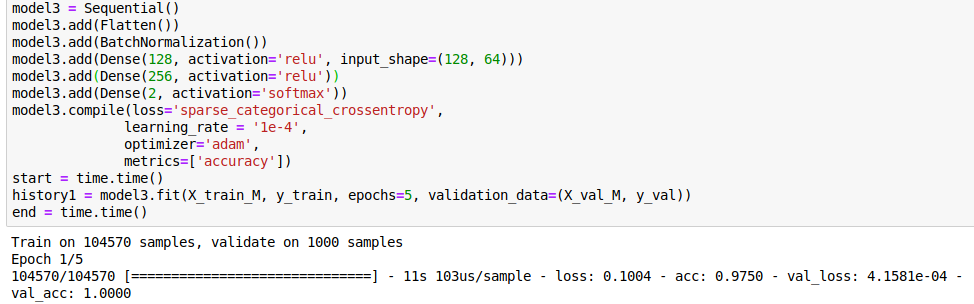
<center>Figure.1 model3</center>

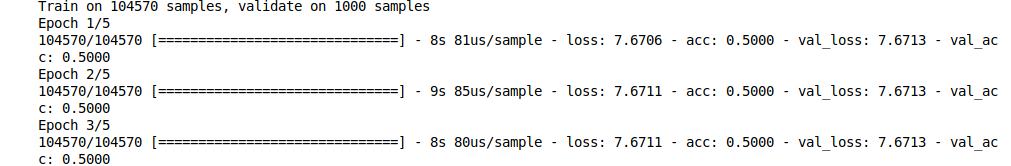
<center>Figure.2 using binaray_crossentropy</center>

**I trained 3 different models withou a BN layer with different number of units of dense layers((32, 32), (64, 128) and (128, 256)). THe loss always keep decresing in the first epochs of training while then it keeps at around 0.32.**
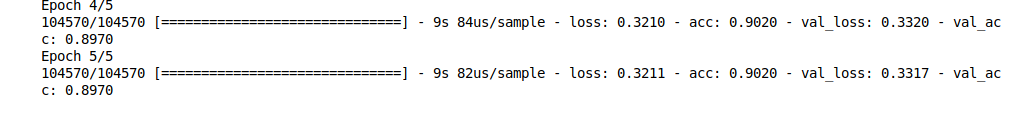
<center>Figure.3 with (128,256) units</center>

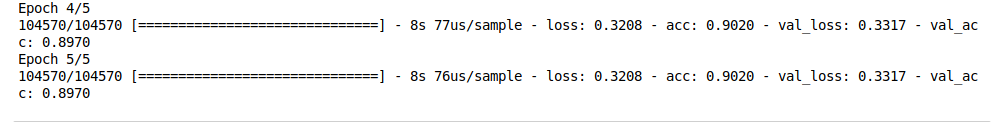
<center>Figure.4 with (32,32) units</center>

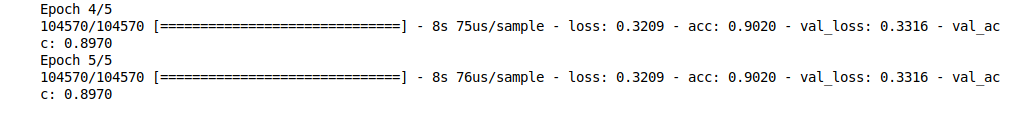
<center>Figure.5 with (64,128) units</center>

**I also tried different learning rates and the results with all learning rates were similar. The precision score and recall scores were not good on '1' which means the same face. In order to prove that there are the same face in training data set, I sampled one from dataset and visualized it.**

**It is clearly that the big change between 'model3' and 'model'(the first model of MLP) is the performance from the results. Predictions of the former one are almost correct and although the latter one has high accuracy, it is not reliable as almost all images mean the negative(different face). So, the first model is not good as it cannot recognize the same face. As we can see it plays an important role for MLP to have enought big dense layer and BN layer. Enough units in dense layer can get more features from images and BN laer sovles the problem named gradient vanishing. It is clearly to see the first model keeps 0.32 loss as it cannot learn the feartures from the images**

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
import time
from sklearn.metrics import classification_report

In [18]:
model = Sequential()
model.add(Flatten())
# model.add(BatchNormalization())
model.add(Dense(64, activation='relu', input_shape=(128, 64)))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              learning_rate = '1e-4',
              optimizer='adam',
              metrics=['accuracy'])
start = time.time()
history = model.fit(X_train_M, y_train, epochs=5, validation_data=(X_val_M, y_val))
end = time.time()

Train on 104570 samples, validate on 1000 samples
Epoch 1/5
104570/104570 [==============================] - 9s 83us/sample - loss: 1.0686 - acc: 0.8842 - val_loss: 0.2926 - val_acc: 0.8970
Epoch 2/5
104570/104570 [==============================] - 8s 79us/sample - loss: 0.2875 - acc: 0.9020 - val_loss: 0.3318 - val_acc: 0.8970
Epoch 3/5
104570/104570 [==============================] - 8s 77us/sample - loss: 0.3207 - acc: 0.9020 - val_loss: 0.3327 - val_acc: 0.8970
Epoch 4/5
104570/104570 [==============================] - 8s 75us/sample - loss: 0.3209 - acc: 0.9020 - val_loss: 0.3316 - val_acc: 0.8970
Epoch 5/5
104570/104570 [==============================] - 8s 76us/sample - loss: 0.3209 - acc: 0.9020 - val_loss: 0.3316 - val_acc: 0.8970


In [19]:
print("runing time:{0}".format(end - start))

runing time:41.45021653175354


In [20]:
prediction = model.predict_classes(X_val_M)
print(classification_report(prediction, y_val))


              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1000
           1       0.00      0.00      0.00         0

    accuracy                           0.90      1000
   macro avg       0.50      0.45      0.47      1000
weighted avg       1.00      0.90      0.95      1000



1


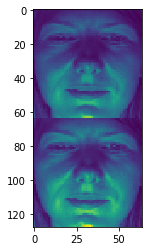

In [76]:
img1 = X_train_M[57].reshape(128, 64)
print(y_train[57])
plt.imshow(img1)

In [21]:
model3 = Sequential()
model3.add(Flatten())
model3.add(BatchNormalization())
model3.add(Dense(128, activation='relu', input_shape=(128, 64)))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(2, activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy',
              learning_rate = '1e-4',
              optimizer='adam',
              metrics=['accuracy'])
start = time.time()
history1 = model3.fit(X_train_M, y_train, epochs=5, validation_data=(X_val_M, y_val))
end = time.time()

Train on 104570 samples, validate on 1000 samples
Epoch 1/5
104570/104570 [==============================] - 11s 103us/sample - loss: 0.1004 - acc: 0.9750 - val_loss: 4.1581e-04 - val_acc: 1.0000
Epoch 2/5
104570/104570 [==============================] - 10s 99us/sample - loss: 0.0212 - acc: 0.9956 - val_loss: 0.0017 - val_acc: 0.9980
Epoch 3/5
104570/104570 [==============================] - 10s 96us/sample - loss: 0.0166 - acc: 0.9968 - val_loss: 3.3312e-05 - val_acc: 1.0000
Epoch 4/5
104570/104570 [==============================] - 10s 96us/sample - loss: 0.0116 - acc: 0.9977 - val_loss: 4.7072e-06 - val_acc: 1.0000
Epoch 5/5
104570/104570 [==============================] - 10s 96us/sample - loss: 0.0104 - acc: 0.9985 - val_loss: 0.0324 - val_acc: 0.9950


In [23]:
print("runing time:{0}".format(end - start))

runing time:52.137285470962524


In [22]:
prediction = model3.predict_classes(X_val_M)
print(classification_report(prediction, y_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       0.96      0.99      0.98       100

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.99      1000
weighted avg       1.00      0.99      1.00      1000



###  build MLP by sklearn
From the results of these 2 ways, we can see the accuracy of them is similar while it is not good enough on recognizing the images which show the same face.

I cannot use this model training all data at the same time as there was a memory overflow problem, so I decided to use 5000 images to train the model. As we can see, there is a fluctuation in loss function. Then I used 'adaptive' learning rate for training, we can see it cannot recognize the images show the same face as well, although the loss is keeping reducing.

In [29]:
from sklearn.neural_network import MLPClassifier

nn_mclf = MLPClassifier(solver='sgd',verbose='true',validation_fraction=0.0)

nn_mclf.fit(X_train_M[:5000], y_train[:5000])

Iteration 1, loss = inf
Iteration 2, loss = 0.64760575
Iteration 3, loss = 0.42008404
Iteration 4, loss = 0.44868461
Iteration 5, loss = 0.46456272
Iteration 6, loss = 0.68337258
Iteration 7, loss = 0.65738980
Iteration 8, loss = 0.62247933
Iteration 9, loss = 0.59121218
Iteration 10, loss = 0.56379479
Iteration 11, loss = 0.53961575
Iteration 12, loss = 0.51799291
Iteration 13, loss = 0.49911911
Iteration 14, loss = 0.48202371
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.0, verbose='true', warm_start=False)

In [30]:
prediction = nn_mclf.predict(X_train_M[:1000])
print(classification_report(prediction, y_train[:1000]))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1000
           1       0.00      0.00      0.00         0

    accuracy                           0.92      1000
   macro avg       0.50      0.46      0.48      1000
weighted avg       1.00      0.92      0.96      1000



/root/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [100]:
nn_mclf1 = MLPClassifier(solver='sgd',verbose='true', learning_rate='adaptive',validation_fraction=0.0)

nn_mclf1.fit(X_train_M[:5000], y_train[:5000])

Iteration 1, loss = inf
Iteration 2, loss = 0.28881088
Iteration 3, loss = 0.26391992
Iteration 4, loss = 0.25003314
Iteration 5, loss = 0.23929900
Iteration 6, loss = 0.23170030
Iteration 7, loss = 0.21803071
Iteration 8, loss = 0.20959776
Iteration 9, loss = 0.19308330
Iteration 10, loss = 0.18618426
Iteration 11, loss = 0.25710631
Iteration 12, loss = 0.26221295
Iteration 13, loss = 0.23256898
Iteration 14, loss = 0.22543564
Iteration 15, loss = 0.22980256
Iteration 16, loss = 0.22632535
Iteration 17, loss = 0.21552896
Iteration 18, loss = 0.20241289
Iteration 19, loss = 0.18346864
Iteration 20, loss = 0.17740082
Iteration 21, loss = 0.17371175
Iteration 22, loss = 0.17415360
Iteration 23, loss = 0.16327382
Iteration 24, loss = 0.19272506
Iteration 25, loss = 0.15995806
Iteration 26, loss = 0.16000650
Iteration 27, loss = 0.16749216
Iteration 28, loss = 0.15293506
Iteration 29, loss = 0.14657213
Iteration 30, loss = 0.14165988
Iteration 31, loss = 0.16378268
Iteration 32, loss = 0.1

/root/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.0, verbose='true', warm_start=False)

In [103]:
prediction = nn_mclf.predict(X_val_M)
print(classification_report(prediction, y_val))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1000
           1       0.00      0.00      0.00         0

    accuracy                           0.90      1000
   macro avg       0.50      0.45      0.47      1000
weighted avg       1.00      0.90      0.95      1000



/root/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## 2.4 Classification Comparison

From the results, we can see the accuracy of both 2 ways is high enough. Particularly, It can also detect the same face into 2 images in the new data set for MLP and the match_template can do as well while its performance is not good as well as the MLP. The reason why MLP can obtain high accuracy .

Except these results I also recorded running time of these two part. It took at least 230 seconds for matching while the MLP just took about less than 4 seconds. So, in the performance of efficiency, MLP is better. For training effort, in threshold 0.75, match_template(0.1)(*Figure.6*) is higher than the MLP which(0.0104)(*Figure.7*). So, the performance of the MLP model is better on accuracy. 

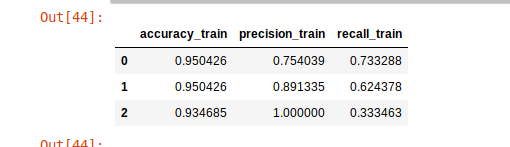
<center>Figure.6 match_template</center>

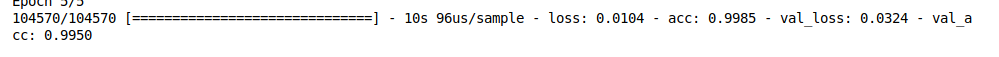
<center>Figure.7 MLP</center>

For generalization, we can see the accuracy(0.95) of this data set is similar to that of the training data set(0.95) and the testing data set(0.95), which means it has a good generalization. The MLP has better generalization ablitity as the accuracy and precision scores are so high.

In [20]:
file_list2, image_list2 = load_images(dir2)
df2 = pd.DataFrame({'filenames':file_list2, 'images':image_list2})

# creat label
y2 = creat_label(df2)

### match_template

I choose 0.75 as the threshold because it get high accuracy and precision and recall score on last model.

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
start1 = time.time()
res2 = match(df2)
# set 0.75 as the threshold
end1 = time.time()
start2 = time.time()
y2_pred = pred(0.75, res2)
end2 = time.time()
print("runing time:{0}".format(end1-start1))
print("accuracy:{0}".format(accuracy_score(y2, y2_pred)))
print("precision_score:{0}".format(precision_score(y2, y2_pred)))
print("recall_score:{0}".format(recall_score(y2, y2_pred)))

runing time:236.03909063339233
accuracy:0.950402576489533
precision_score:0.7540234452612756
recall_score:0.7333333333333333


In [38]:
start2 = time.time()
y2_pred = pred(0.75, res2)
end2 = time.time()
end2-start2

0.18110442161560059

### MLP
Model3 is compared to match_template

In [21]:
# creat test data in sub31to40
X2 = preprocessing(df2)

In [25]:
start1 = time.time()
prediction = model3.predict_classes(X2)
end1 = time.time()
print("runing time:{0}".format(end1-start1))
print(classification_report(prediction, y2))

runing time:3.6663525104522705
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     95220
           1       1.00      1.00      1.00     10350

    accuracy                           1.00    105570
   macro avg       1.00      1.00      1.00    105570
weighted avg       1.00      1.00      1.00    105570



test of model with 2 dense layer and without BN layer.

In [19]:

start1 = time.time()
prediction = model.predict_classes(X2)
end1 = time.time()
print("runing time:{0}".format(end1-start1))
print(classification_report(prediction, y2))

runing time:2.720876932144165
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    105570
           1       0.00      0.00      0.00         0

    accuracy                           0.90    105570
   macro avg       0.50      0.45      0.47    105570
weighted avg       1.00      0.90      0.95    105570



/root/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## 2.5 Bonus
I combine match_template and MLP(the model without BN layer) to increase the model accuracy. The reason why I use the model without BN layer is that with BN layer the MLP is good enough and I want to increase the performance of MLP without BN layer.
I use the results from match template as the training data. From the results, we can see the accuracy(0.95) is higher than the old MLP. This method sacrifices time performance but achieves better a moodel with better generalization. I also test the model on sub31to40 data set which got good results as well, although it still not good enouth than the MLP model with BN layer.

In [11]:
model_new = Sequential()
# model_new.add(Flatten())
model_new.add(Dense(64, activation='relu'))
model_new.add(Dense(128, activation='relu'))
model_new.add(Dense(2, activation='softmax'))
model_new.compile(loss='sparse_categorical_crossentropy',
              learning_rate = '1e-4',
              optimizer='adam',
              metrics=['accuracy'])
start = time.time()
history_new = model_new.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Train on 104570 samples, validate on 1000 samples
Epoch 1/10
104570/104570 [==============================] - 4s 43us/sample - loss: 0.1548 - acc: 0.9526 - val_loss: 0.1503 - val_acc: 0.9500
Epoch 2/10
104570/104570 [==============================] - 4s 41us/sample - loss: 0.1408 - acc: 0.9557 - val_loss: 0.1470 - val_acc: 0.9500
Epoch 3/10
104570/104570 [==============================] - 4s 41us/sample - loss: 0.1400 - acc: 0.9556 - val_loss: 0.1564 - val_acc: 0.9500
Epoch 4/10
104570/104570 [==============================] - 4s 42us/sample - loss: 0.1404 - acc: 0.9554 - val_loss: 0.1464 - val_acc: 0.9490
Epoch 5/10
104570/104570 [==============================] - 4s 43us/sample - loss: 0.1401 - acc: 0.9555 - val_loss: 0.1468 - val_acc: 0.9510
Epoch 6/10
104570/104570 [==============================] - 4s 42us/sample - loss: 0.1396 - acc: 0.9558 - val_loss: 0.1466 - val_acc: 0.9540
Epoch 7/10
104570/104570 [==============================] - 5s 47us/sample - loss: 0.1397 - acc: 0.9555 

In [13]:
prediction = model_new.predict_classes(X_val)
print(classification_report(prediction, y_val))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       911
           1       0.69      0.80      0.74        89

    accuracy                           0.95      1000
   macro avg       0.83      0.88      0.86      1000
weighted avg       0.95      0.95      0.95      1000



**On sub31to40 data set**

In [28]:
result2 = match(df2)

In [29]:
prediction = model_new.predict_classes(result2)
print(classification_report(prediction, y2))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     96476
           1       0.71      0.81      0.75      9094

    accuracy                           0.95    105570
   macro avg       0.84      0.89      0.86    105570
weighted avg       0.96      0.95      0.96    105570



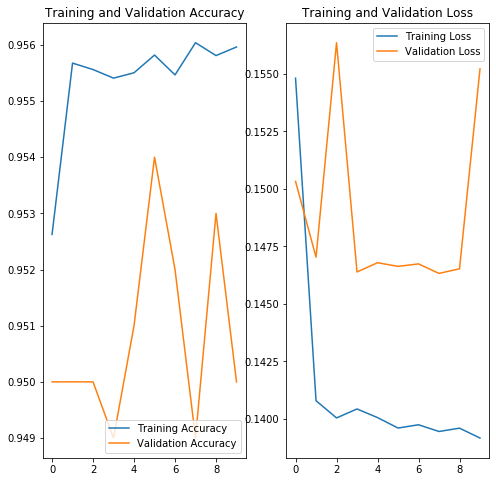

In [16]:
acc = history_new.history['acc']
val_acc = history_new.history['val_acc']

loss = history_new.history['loss']
val_loss = history_new.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 2.6 Conclusion 
1. MLP has better time performance than template matching.
2. There will be a gradient vanishing problem when we are training the MLP model. I searched the connection about training loss and testing loss. I checked the label and data set for preventing that raining set and label do not correspond. I changed learning rate and found the results were almost same. After that, I maked sure that there is a gradient vanishing problem.
3. Adding batch normalization way would prevent gradient vanishing.
4. The performance of template matching relys on the threshold which is too subjective and not rigorous